<div style="text-align: right"><sub>This notebook is distributed under the <a href="https://creativecommons.org/licenses/by-sa/4.0/" target="_blank">Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license</a>.</sub></div>
<h1>Hands on Machine Learning  <span style="font-size:12px;"><i>by <a href="https://webgrec.ub.edu/webpages/000004/cat/dmaluenda.ub.edu.html" target="_blank">David Maluenda</a></i></span></h1>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://atenea.upc.edu/course/view.php?id=95161" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/upc_logo_49px.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/dmaluenda/hands_on_machine_learning/blob/master/04_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/dmaluenda/hands_on_machine_learning/blob/master/04_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/04_Reinforcement_Learning.ipynb"  target="_blank"
          download="04_Reinforcement_Learning">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

# $\text{IV}$. Reinforcement Learning

Hands on "Machine Learning on Classical and Quantum data" course of
[Master in Photonics - PHOTONICS BCN](https://photonics.masters.upc.edu/en/general-information)
[[UPC](https://photonics.masters.upc.edu/en) +
[UB](https://www.ub.edu/web/ub/en/estudis/oferta_formativa/master_universitari/fitxa/P/M0D0H/index.html?) +
[UAB](https://www.uab.cat/en/uab-official-masters-degrees-study-guides/) +
[ICFO](https://www.icfo.eu/lang/studies/master-studies)].

**Tutorial 4**

This notebook shows how to:
- solve a challenge with reinforcement learning
- implement the Actor-Critic method
- use a Gradient Tape to train non-conventional loss functions

**References**:

[1] [Keras](https://keras.io/getting_started/): a deep learning API written in Python.<br>
[2] [Keras examples](https://keras.io/examples/rl/).<br>
[3] Gym, a toolkit for developing and comparing reinforcement learning algorithms. By [OpenAI](https://gym.openai.com).

## 0. Imports: NumPy, Matplotlib, Tensorflow and <u>gymnasium</u>

We will use the [Gymnasium](https://gymnasium.farama.org/) module to solve a challenging game. You have to install it before, if you do not already have it, just by run the next cell.

In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gymnasium as gym

from time import sleep, time

# For simple animation
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

## 1. CartPole game from OpenAI gymnasium

We will use the CartPole game. Documentation: https://gymnasium.farama.org/environments/classic_control/cart_pole/

This cell will draw a FIgure with a cart and an upstanding pole. This is just a window where to show the current state of the game. Check the two printed lines and the last code line to draw the environ.

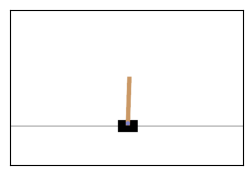

In [10]:
MODE = "rgb_array"  #  "human"  #  

def render(env, rewards=None):
    if MODE == "rgb_array":
        clear_output(wait=True)
        plt.figure(figsize=(3,3))
        plt.title(f"Total rewards: {rewards}") if rewards else None
        plt.imshow(env.render())
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        env.render()
            

env = gym.make("CartPole-v0", render_mode=MODE)  # Create the environment

reset_output = env.reset()
print(f"reset_output: {reset_output}")
state = reset_output[0]
print(f"state: {state}")

fig = render(env)  # This creates a figure, open it and make it always visible

A summary of the documentation's game is:

* **Action Space**

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    
    | Num | Action                 |
    |-----|:-----------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |

* **State Space**

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |

* **Rewards**

    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted.


* **Starting State**

    All observations are assigned a uniformly random value in `(-0.05, 0.05)`


* **Episode Termination**

    The episode terminates if any one of the following occurs:
    1. Pole Angle is greater than ±12°
    2. Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 200.

Run the `env.step()` function. You have to set an action as argument. Take the returning parameters and print them. What are them? Check https://gymnasium.farama.org/api/env/#gymnasium.Env.step . Pay special attention to the first three returned parameters.

In [3]:
state, reward, done, info, _ = env.step(1)
print(reward)

1.0


## 2. Neural network player (Actor-Critic Agent)

The Agent in Actor-Critic reinforcement learning is a single NN model with two separate output layers, one for Actor, one for Critic.

* **Actor** try to decide which action is better for a given environmental state. In this case we have two possible actions (move to left or to right), then a two softmax neurons as output is the choice.

* **Critic** try to estimate the next reward, according to the current state. A single output neuron with no activation function (linear) is enough.

In both cases we use the same input block containing the input layer (with as many neurons like the state shape) and a hidden layer of a certain number of neurons, 128 for instance. The hidden block might be any combination of any type of layers.

Define a neural network to be your Agent. Since it needs to have two separated outputs, use the functional approach.

Do not compile the model, since we will train it on our own. Just print the summary to check the layers sizes and connections.

In [4]:
num_inputs = 4    # state space
num_actions = 2   # action space
num_hidden = 128  # free hyper-parameter

inputs = layers.Input(shape=(num_inputs,))
hidden = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(hidden)
critic = layers.Dense(1, activation=None)(hidden)

model = keras.Model(inputs=inputs, outputs=[action, critic])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 4)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 2)                 │             258 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │             129 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,027 (4.01 KB)

 Trainable params: 1,027 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Call your model with the current state from the environ. What Tensor.shape the model expects and returns? Why? How to solve it? Check https://numpy.org/doc/2.2/reference/constants.html#numpy.newaxis 

In [5]:
output = model(state[np.newaxis, :])

actor_out, critic_out = output

actor_probs = actor_out[0,:]
critic_value = critic_out[0,:]

## 3. Playing function

Write a function to play a complete game (episode) of the CartPole using the model as a player. Take as argument a boolean flag to render the game (illustrative purposes) or not (training purposes).

The function have to return the history of the game, useful for training. It is three lists: 1. the partial reward obtained in every step, 2. the probabilities predictions by actor in every step, and 3. the critic values predicted in every step. 

The first step of the function is to reset the environ and to get the initial state.

Then, make a ***while*** loop until the environ returns `terminated=True`.

Inside the loop:

1. Run your model to get the probabilities from the actor and a value from the critic, according to the current state. Think about the Tensor sizes.
2. Random choose an action, taking into account the probabilities predicted by the actor. Check the `p` parameter of <u>[numpy.random.choice()](https://numpy.org/doc/2.1/reference/random/generated/numpy.random.choice.html)</u>. This will introduce some noise when probabilities are about fifty-fifty, it is more human. Also, it helps to explore more possibilities while training.
3. Apply the action to the environ with the `step()` function and take the new current state, the reward and if the game has terminated.
4. Render the current environ by calling the `render(env, rewards)` function only if the argument flag is True. Pass the currently cumulated rewards as argument. This is the sum of all previous (and current) rewards. Check the `sum()` function for in-built lists.
5. Populate the returning lists. **The probabilities list has to be populated just with the probability obtained for the action done**, while discarding the probability of other actions not done. 

Finally, return these three history lists.

In [8]:
def play(do_render=True):

    rewards_list = []
    probabilities_list = []
    critic_list = []
    
    state = env.reset()[0]  # let's start a new game. It returns the initial state, and something else ignored
    done = False  # it's not done at the very beginning
    final_mark = 0
    fig = None
    
    while not done:
        state_batch = state[None,:]  # from state to a batch
        
        prob_batch, critic_batch = model(state_batch)

        prob = prob_batch[0,:]       # from batch to true values
        critic = critic_batch[0, :]  # from batch to true values

        action = np.random.choice(num_actions, p=prob.numpy())

        # apply an action and get the new information
        state, reward, done, info, _ = env.step(action)
        render(env, sum(rewards_list)) if do_render else None
        
        rewards_list.append(reward)
        probabilities_list.append(prob[action])
        critic_list.append(critic)
    
    return rewards_list, probabilities_list, critic_list

Run the play function, and print the returned lists.

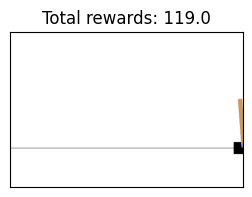

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[<tf.Tensor: shape=(), dtype=float32, numpy=0.5197371244430542>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8826255202293396>, <tf.Tensor: shape=(), dtype=float32, numpy=0.43847450613975525>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9252613186836243>, <tf.Tensor: shape=(), dtype=float32, numpy=0.394960880279541>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9378207921981812>, <tf.Tensor: sh

In [19]:
rw_list, prob_list, crit_list = play()

print(rw_list)
print(prob_list)
print(crit_list)

## 4. Reinforcement training

We will follow the Actor-Critic algorithm, check for instance: https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14

<hr>

We have access to the game's history through three lists:
 * **Action probabilities**: Probability predicted by actor of the given action and for a certain state $\pi_{\theta}(a|s)$.
 * **Critic values**: Value predicted by critic $V_{\phi}(s)$.
 * **Rewards** $r_t$: $+1$ for each step in CartPole.

There is an extra hyperparameter that is  the **Discount Factor** $\gamma$.

<hr>

First, let's define four functions to atomize the whole process:

**1. Discounted Returns (gain)**.
After the episode finishes, the total discounted return $G_t$ for each step $t$ is
\begin{equation}
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k}
\end{equation}
It is a list of values, where $t=0,1,2,\dots,T-1$ is the time step index.

Write a function to compute the equation above. It should take a list of rewards as argument and return a same size list according to the equation.

$\gamma$ can be an extra argument. For games where more time means better result, it should be near to one. For games where as shorter as better, it should be near to 0. Let's set it to 0.99.

In [13]:
def gain(rw_list, gamma=0.99):

    gains = []
    g = 0
    
    for r in rw_list[::-1]:
        g = r + gamma*g
        gains.append(g)

    return gains[::-1]

**2. Advantage**.
The advantage $A_t$ indicates how much better an action is compared to the critic's expectation:
\begin{equation}
A_t = G_t - V_{\phi}(s_t)
\end{equation}
Again, it is a list of $T$ itmes.

Write a function to calculate the Advantage the Actor takes from the Critic. Take the rewards list and the critic's predictions list from the arguments, compute the discounted returns $G$ using the function you just create and compute the new list for the advantage token in every time step.

In [14]:
def advantatge(rw_list, critics):
    
    return [g-v for g, v in zip(gain(rw_list), critics)]

**3. Actor Loss**. 
The actor loss is defined to maximize the policy performance. Since the *** We minimize the negative log-probability of selected actions weighted by the advantage:
\begin{equation}
L_{\text{actor}}(\theta) = -\frac{1}{T}\sum_{t=0}^{T-1}\log \pi_{\theta}(a_t|s_t) \cdot A_t
\end{equation}

Write a function to calculate the actor loss. Take as argument the rewards lists, the probabilities predictions list $[\pi_\theta]$ and the critic's predictions list. Compute the advantage using the function above. The actor loss has to be just an average number.

To make the logarithm, use the `tensorflow.keras.ops.log()` function.

In [15]:
def actor_loss(rw_list, prob_list, critics):
    
    T = len(rw_list)

    adv_list = advantatge(rw_list, critics)

    out = 0
    for prob, adv in zip(prob_list, adv_list):
        out += keras.ops.log(prob)*adv

    return -out/T

**4. Critic Loss**.
The critic is trained to minimize the Mean Squared Error (MSE) between the estimated state values $V_{\phi}(s_t)$ and the computed returns $G_t$:
\begin{equation}
L_{\text{critic}}(\phi) = \frac{1}{T}\sum_{t=0}^{T-1}\left(G_t - V_{\phi}(s_t)\right)^2
\end{equation}

Write a function to compute the averaged critic loss from the rewards list and the critic predictions list.

In [16]:
def critic_loss(rw_list, critics):
    T = len(rw_list)
    return sum([(g-c)**2 for g, c in zip(gain(rw_list), critics)])/T

OK, now let's use all this small functions to compute the gradients and train the model.

<hr>

We will use the `Adam` optimizer from `keras.optimizers`.

Since we will manually applay the gradients using [its own funciton](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam#apply), we do not need to compile the model with this optimizer, but we just need to define a variable with this optimizer with a certain learning rate, e.g. $\eta=0.005$.

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)

Let's train the model just by playing some (or many) complete games and learning from the rewards obtained.

Do a *while* loop until the game is considered solved by the model. This is when it reaches 200 points for a single play.

Then, in the while loop:

1. Open a `tenosrflow.GradinetTape()` using a `with ... as ... :` block (https://www.tensorflow.org/guide/autodiff).
   * Inside the `with_as` block:
     1. Play a complete game using the function done in section 1.3 and get the lists of rewards, probability prediction, and critic predictions for that episode. Pass a True for the rendering flag just every 10 training loops, since it takes time and this will speed up the training.
     2. Get the actor and critic losses using the functions done before, and compute the total loss just by summing them.
<br>
<br>
2. Compute the gradient using `tape.gradient(loss, variables)`, where loss is the total loss computed inside the `with_as` block, and the variables are the trainable variables of your model (`model.trainable_variables`). It returns the gradient.
<br>
<br>
4. Apply the gradient to the model using the Adam optimizer defined above, using the `apply(grad, variables)` function of your optimizer, where `grad` is the gradient returned by the tape and `variables` are those trainable of your model.
<br>
<br>
5. Check the total obtained points in this current episode (the sum of rewards_list), and print it. Use `print(points, end=', ')` to avoid many printed lines.
<br>
<br>
6. Store the total obtained points in a history list.

Count the episodes required to train your model (the number of passes on this while loop), and print it when the loop finishes.

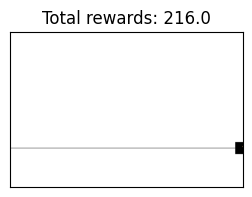

217.0, Solved at episode 161 with 235.53787851333618 seconds.


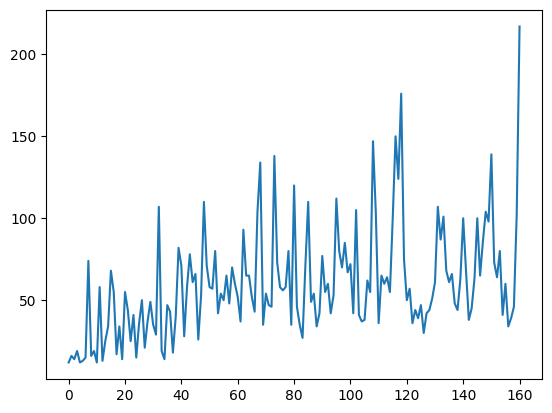

In [18]:
alpha = 1

history = []
t0 = time()
current_total_reward = 0

while current_total_reward<200:  # Episodies loop: like epochs. Each play-loop is an episode

    with tf.GradientTape() as tape:  # this will register all trainable parameters in a tape, to be able to find the gradient afterwards   

        rewards_list, probs_predictions, critic_predictions = play(not len(history)%10)
        
        total_loss = (actor_loss(rewards_list, probs_predictions, critic_predictions) +
                      alpha * critic_loss(rewards_list, critic_predictions))
        
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

    current_total_reward = sum(rewards_list)
    
    # Log details
    history.append(current_total_reward)
    print(current_total_reward, end=', ')
    

print(f"Solved at episode {len(history)} with {time()-t0} seconds.")

plt.plot(history)

Plot the history to check the evolution.

## 5. Checking the model

Play again a complete game calling the function written in section 1.3 and check its behavior and the total reward obtained.

In [ ]:
play()

In some cases, the model reaches the target rewards during the training just by luck. Check the obtained points' evolution. If it is consistent, probably you have just gotten a good behavior in this last play. However, if it suddenly reached the maximum, probably it was by luck.

If the last, you can re-run the learning cell. It will continue with the training, not from the beginning, just continuing.

Finally, let's close the environ, and the `pygame window`.

In [ ]:
env.close()